# Manual masking of LPD data

With this GUI application, you can create masks for the LPD1M detector.

Written by Tobias Eklund and Yizhi Liu (2025)

## Prerequisites

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import xarray as xr

from extra.components import XrayPulses
from extra_data import DataCollection, RunDirectory, by_index, open_run
from extra.components import Scan, Scantool, OpticalLaserDelay
from extra.utils import imshow2
from extra_data.components import LPD1M
from extra_geom import LPD_1MGeometry

%matplotlib widget

from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap as LCm

from IPython.display import clear_output
from ipywidgets import *

# provide an LPD geometry for the experiment
geom_file = 'example_data/LPD_geom.h5'
geom = LPD_1MGeometry.from_h5_file(geom_file)


## Load data

In [2]:
# Load the included example data.
imdata = xr.load_dataarray('example_data/imdata.h5')
maskdata = xr.load_dataarray('example_data/maskdata.h5')


In [3]:
# Or, enter an FXE proposal and run number
proposal = 7944
run_nr = 60

run = open_run(proposal, run_nr, data="all") 
run_LPD=LPD1M(run)

# Load the data as xarray data arrays. For the following, it's easier to unstack the multi-index train_pulse into coordinates trainId and pulseId.
# Image data
imdata = run_LPD["image.data"].xarray().unstack()
# Pipeline mask
maskdata = run_LPD["image.mask"].xarray().unstack()

#Pipe mask is the same for every train, no need to keep them all here
maskdata = maskdata[:,:,:,0,:]


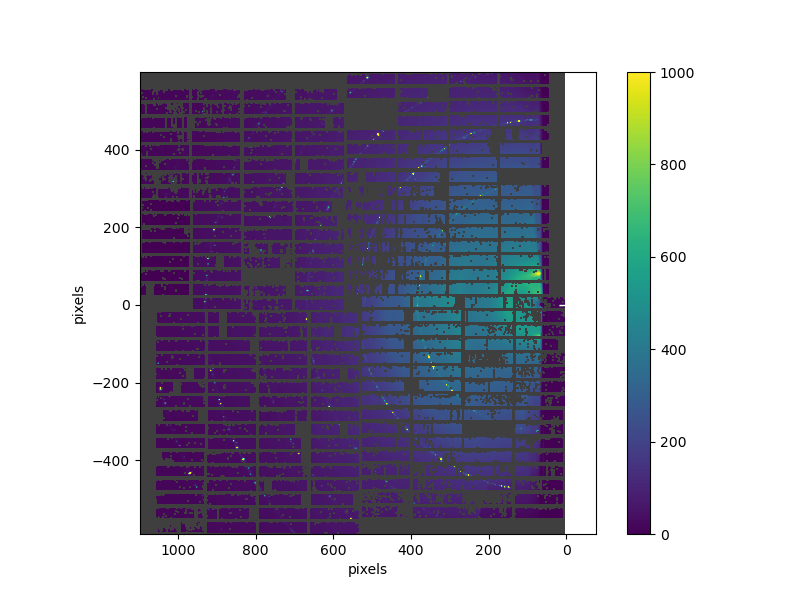

In [4]:
preview_img = imdata.where(~maskdata.astype('bool')).isel(pulse=0).mean(dim='train')

# Preview image
test=geom.plot_data(preview_img, vmin=0, vmax=1000)
test.get_figure().set_size_inches(8,6)


## Manual masking with geometry correction

To get rid of the remaining artifacts, we mask some parts manually. This might have to be done per train and pulse. Below is a simple GUI to mask out modules, tiles, chips, or quadrants in individual (or all) trains/pulses. Performance is SUPER SLOW. Sorry about that, I did not have time to optimize this. If it feels like nothing is happening after clicking, check if the bottom bar says 'Idle' or 'Busy'. If busy, please just be patient.

Left click to mask, right click to unmask!

It might make sense to use pyFAI-drawmask instead of this tool to freehand draw a base mask for a certain detector position. Maybe someone cancome up with a better way to do this?

The manual masking could be made more efficient by splitting into static mask (all trains/pulses) and dynamic mask (containing only trains/pulses that are different from the static mask. I have done no work on this. 

In [5]:
# Initiate fresh mask
manual_mask = xr.zeros_like(imdata).astype(np.uint8)


In [6]:
# This box contains a mess of necessary things. Run once, but can stay hidden.

red = LCm(["none", "red"])
magenta = LCm(["none", "magenta"])


len_pulse = imdata.shape[-1]
len_train = imdata.shape[2]


def transform_data(data):
    return geom._snapped().position_modules(data)[0]
    
#coordinate map

mxy = np.mgrid[0:16:1,0:256:1, 0:256:1]
m_vals = mxy[0, ...] + 1 # add 1 because position_modules uses zero as dummy value
y_vals = mxy[1, ...] + 1
x_vals = mxy[2, ...] + 1

map_m = transform_data(m_vals)
map_m = np.where(map_m!=0,map_m-1,np.nan)
map_x = transform_data(x_vals)
map_x = np.where(map_x!=0,map_x-1,np.nan)
map_y = transform_data(y_vals)
map_y = np.where(map_y!=0,map_y-1,np.nan)


get_ipython().run_line_magic("matplotlib", "widget")

def init_plot():

    global fig2_img_plot_data
    global fig2_mask_plot_data
    global fig2_manual_mask_plot_data

    #Yizhi----------------------------------------------------------------------------------------
    fig2_img_array = imdata[:, :, :,fig2_train, fig2_pulse].values
    fig2_mask_array = maskdata[:, :, :, fig2_pulse].values
    fig2_manual_mask_array = manual_mask[:, :, :,fig2_train, fig2_pulse].values
    
    fig2_img_plot_data = transform_data(fig2_img_array)
    fig2_mask_plot_data = transform_data(fig2_mask_array)
    fig2_manual_mask_plot_data = transform_data(fig2_manual_mask_array)

    global fig2_img
    global fig2_mask
    global fig2_manual_mask
    
    fig2_img = ax2.imshow(fig2_img_plot_data, aspect="equal",vmin=0, vmax=clip)
    fig2_mask = ax2.imshow(fig2_mask_plot_data, cmap=red, aspect="equal",vmin=0,vmax=1)
    fig2_manual_mask = ax2.imshow(fig2_manual_mask_plot_data, cmap=magenta,aspect="equal",vmin=0, vmax=1)

    ax2.set_title(f"Train {fig2_train}, pulse {fig2_pulse}")

def update_train_pulse():

    fig2_img_array = imdata[:, :, :,fig2_train, fig2_pulse].values
    fig2_mask_array = maskdata[:, :, :,  fig2_pulse].values
    fig2_manual_mask_array = manual_mask[:, :, :,fig2_train, fig2_pulse].values
    
    fig2_manual_mask_plot_data = transform_data(fig2_manual_mask_array)
    fig2_img_plot_data = transform_data(fig2_img_array)
    fig2_mask_plot_data = transform_data(fig2_mask_array)
    
    fig2_img.set_clim(vmax=clip_slider.value)
    fig2_img.set_data(fig2_img_plot_data)
    fig2_mask.set_data(fig2_mask_plot_data)
    fig2_manual_mask.set_data(fig2_manual_mask_plot_data)
    
    ax2.set_title(f"Train {fig2_train}, pulse {fig2_pulse}")

def update_manual_mask():

    
    ax2.set_title(f"Train {fig2_train}, pulse {fig2_pulse}")
    # fig2.canvas.draw_idle()
    
########## Interactive stuff

def on_button_next_train(b):

    global fig2_train
    global fig2_pulse

    if fig2_train < len_train - 1:
        fig2_train += 1

        update_train_pulse()

def on_button_prev_train(b):

    global fig2_train
    global fig2_pulse

    if fig2_train > 0:
        fig2_train -= 1
        update_train_pulse()

def on_button_next_pulse(b):

    global fig2_pulse
    global fig2_train

    if fig2_pulse < len_pulse - 1:
        fig2_pulse += 1

        update_train_pulse()

def on_button_prev_pulse(b):

    global fig2_pulse
    global fig2_train

    if fig2_pulse > 0:
        fig2_pulse -= 1

        update_train_pulse()

# Mouse-click in plot
def onclick(event):
    global manual_mask
    
    if event.button == 1:
        fill_value = 1
    elif event.button == 3:
        fill_value = 0

    #read mouse click coordinates
    clicked_m = int(map_m[int(event.ydata.round()), int(event.xdata.round())])
    clicked_x = int(map_x[int(event.ydata.round()), int(event.xdata.round())])
    clicked_y = int(map_y[int(event.ydata.round()), int(event.xdata.round())])
    print(clicked_m,clicked_x,clicked_y)
    
    match mask_in_all_trains.value:
        case True:
            train_sel = slice(0,len_train)
        case False:
            train_sel = fig2_train
    match mask_in_all_pulses.value:
        case True:
            pulse_sel = slice(0,len_pulse)
        case False:
            pulse_sel = fig2_pulse

    match selection.value:
        case 'Module':
            manual_mask[clicked_m,:,:,train_sel,fig2_pulse] = fill_value
        case 'Chip':
            x_min=int(clicked_x/16)*16
            x_max=x_min+16
            y_min=int(clicked_y/32)*32
            y_max=y_min+32
            manual_mask[clicked_m,y_min:y_max,x_min:x_max,train_sel,pulse_sel] = fill_value
        case 'Tile':
            x_min = int(clicked_x/128)*128
            x_max = x_min + 128
            y_min=int(clicked_y/32)*32
            y_max=y_min+32
            manual_mask[clicked_m,y_min:y_max,x_min:x_max,train_sel,pulse_sel] = fill_value
    
    fig2_manual_mask_array = manual_mask[:, :, :,fig2_train, fig2_pulse].values
    fig2_manual_mask_plot_data = transform_data(fig2_manual_mask_array)
    fig2_manual_mask.set_data(fig2_manual_mask_plot_data)



Button(description='Redraw (update clip)', style=ButtonStyle())

FloatSlider(value=445.1536560058594, description='Clip', layout=Layout(width='1000px'), max=1507.4945)

Dropdown(description='Selection:', options=('Chip', 'Tile', 'Module'), value='Chip')

Dropdown(description='Mask in:', options=(('All trains', True), ('This train', False)), value=True)

Dropdown(description='Mask in:', options=(('All pulses', True), ('This pulse', False)), value=True)

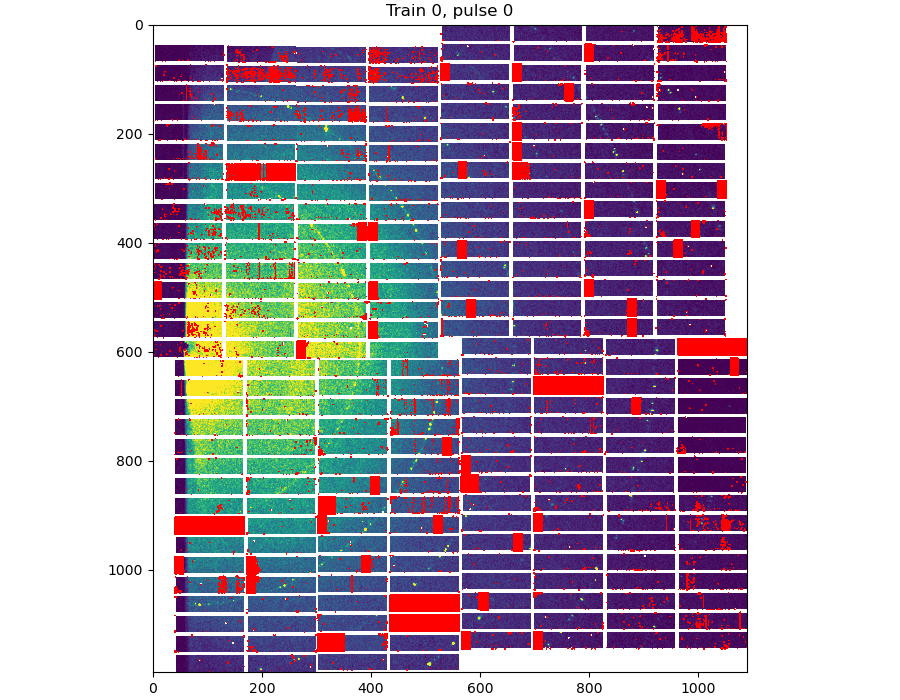

In [7]:
# GUI Buttons.

button_next_train = Button(description="Train +")
button_prev_train = Button(description="Train -")
button_next_pulse = Button(description="Pulse +")
button_prev_pulse = Button(description="Pulse -")
button_redraw = Button(description="Redraw (update clip)")

display(HBox([button_prev_train, button_next_train]))
display(HBox([button_prev_pulse, button_next_pulse]))
display(button_redraw)

button_next_train.on_click(on_button_next_train)
button_prev_train.on_click(on_button_prev_train)
button_next_pulse.on_click(on_button_next_pulse)
button_prev_pulse.on_click(on_button_prev_pulse)
button_redraw.on_click(lambda x: update_train_pulse())

# GUI slider

# Set initial vmax (clipping level)
clip = imdata.median()

slider_length='1000px'
clip_slider = FloatSlider(description='Clip', min=0, max=imdata.max()/1E3, layout=Layout(width=slider_length,valstep=np.logspace(-10,1,100)), value=clip)
display(clip_slider)

#GUI drop-downs

selection = widgets.Dropdown(
    options=['Chip', 'Tile','Module'], description="Selection:"
)
mask_in_all_trains = widgets.Dropdown(
    options=[("All trains", True), ("This train", False)], description="Mask in:"
)
mask_in_all_pulses = widgets.Dropdown(
    options=[("All pulses", True), ("This pulse", False)], description="Mask in:"
)

display(selection, mask_in_all_trains, mask_in_all_pulses)  # ,mask_unmask)



fig2_train = 0  # plot_train_index
fig2_pulse = 0  # plot_pulse_index

# Initialize figure
fig2, ax2 = plt.subplots(figsize=(9,7),constrained_layout=True) #Make it bigger

init_plot()
cid = fig2.canvas.mpl_connect("button_press_event", onclick)

In [11]:
manual_mask.to_netcdf('manual_mask.h5')